# Graphing

## Setup

In [161]:
import matplotlib
import parselmouth
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import pandas as pd
from math import ceil
from matplotlib.ticker import MaxNLocator
%matplotlib inline
plt.style.use('ggplot')

In [162]:
%load_ext autoreload
%autoreload 1
%aimport graphing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
sns.set(font_scale=15/10)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [4]:
# Global parameters

def remove_from_list(lst, idxs):
    if type(idxs) is int:
        return [i for j, i in enumerate(lst) if j != idxs]
    else:
        return [i for j, i in enumerate(lst) if j not in idxs]
    
languages = ["AR", "BG", "CH", "CR", "CZ", "FR", "GE", "JA", "KO", "PL", 
              "PO", "RU", "SP", "SW", "TA", "TH", "TU", "WU", "VN"]
exps = ["mfcc", "mfcc-deltas", "sdc", "pitch", "energy", "pitch-energy", 
        "sdc-pitch-energy", "sdc-pitch", "sdc-energy"]
L = len(languages)

## Plotting segment length distributions

### Length distribution in unsegmented training data

In [324]:
blue = (117/255,162/255,255/255)
blue

(0.4588235294117647, 0.6352941176470588, 1.0)

Utterance lengths from 0.15s to 2229.90s


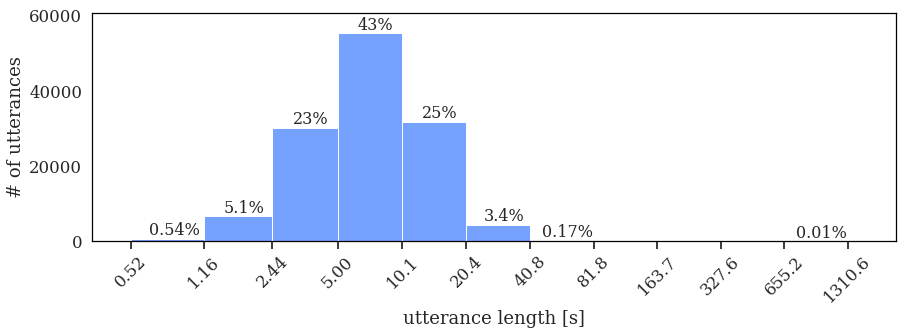

In [325]:
data = pd.read_csv("data/segment-length-data/utt2len-train", delimiter=" ", names=["utt", "len"])
len_min = data["len"].min()
len_max = data["len"].max()
print("Utterance lengths from {:.2f}s to {:.2f}s".format(len_min, len_max))

bins = np.array([(2**i - 12) for i in range(6, 19)])/100
fig = plt.figure(figsize=(13, 5))
plt.xscale('log')
ax = plt.gca()
data_to_plot = data["len"] 
# data_to_plot = data[data["len"] > 5]["len"] 
counts, bins, patches = ax.hist(data_to_plot, bins=bins, color=blue)
ax.set_xticks(bins)
ax.set_xticklabels(["{:.2f}".format(b) if b < 10 else "{:.1f}".format(b) for b in bins])
ymax = np.max(counts)*1.1
ax.set_ylim(bottom=0, top=ymax)
ax.set_xlim(right=len_max)
ax.set_xlabel('utterance length [s]')
ax.set_ylabel('# of utterances')

bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x, patch in zip(counts, bin_centers, patches):
    percent = 100 * int(float(count) / counts.sum() * 10000)/10000
    if percent == 0:
        continue        
    percent = "{:.2g}%".format(percent)
    ax.annotate(percent, xy=(x, count), xycoords=('data'), rotation=0, size=16,
        xytext=(x, count), textcoords='data', va='bottom', ha='center')

ax = graphing.style_axis(ax)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', length=8, direction='out', width=1.5, color="black")
ax.minorticks_off()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

graphing.save_fig(fig, name="lengths-train")

### Length distribution in enroll/eval/test utts

Utterance lengths from 0.31s to 30.01s
Utterance lengths from 0.20s to 10.00s
Utterance lengths from 0.26s to 10.00s
Utterance lengths from 0.26s to 3.00s


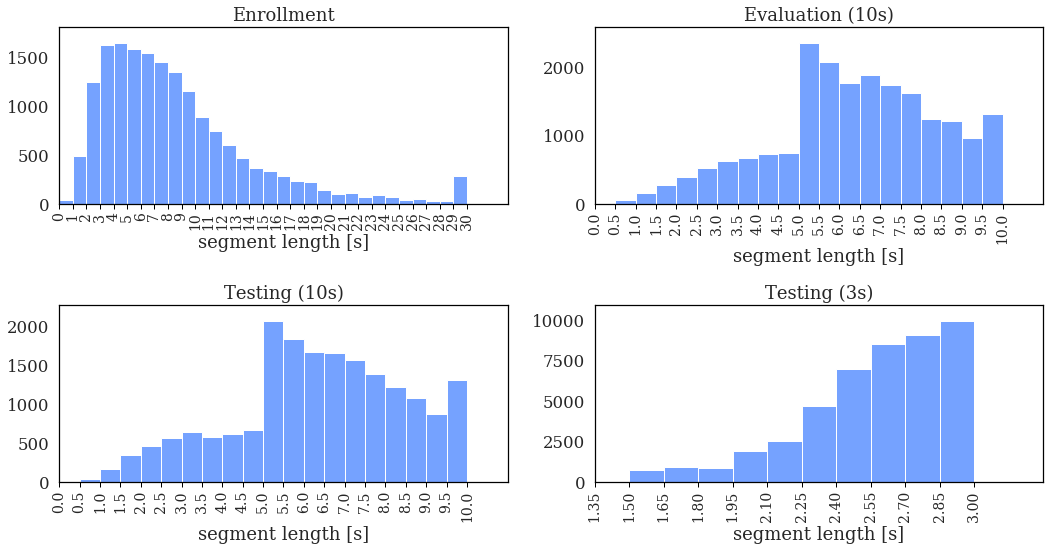

In [375]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
portions = [("enroll", 30, "Enrollment"), ("eval", 10, "Evaluation (10s)"), 
            ("test", 10, "Testing (10s)"), ("test3s", 3, "Testing (3s)")]

for i, (portion, end, title) in enumerate(portions):
    data = pd.read_csv("data/segment-length-data/segments-{}".format(portion), 
                       delimiter=" ", names=["segment", "utt", "start", "end"])
    data["len"] = data["end"] - data["start"]
    len_min = data["len"].min()
    len_max = data["len"].max()
    print("Utterance lengths from {:.2f}s to {:.2f}s".format(len_min, len_max))
    num_bins = max(20, end)    
    bins = np.array(range(num_bins+1))*end/(num_bins)
    
    ax = axes.flatten()[i]
    ax.set_title(title)
    data_to_plot = data["len"]
    counts, bins, patches = ax.hist(data_to_plot, bins=bins, color=blue, label=portion)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins)
    ymax = np.max(counts)*1.1
    ax.set_ylim(bottom=0, top=ymax)
    ax.set_xlim(right=end*1.1, left=(0 if end >= 10 else 1.35))
    ax.set_xlabel('segment length [s]')
    ax = graphing.style_axis(ax)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='major', length=5, direction='out', width=1, color="black")
    ax.minorticks_off()
    
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(
        "%0.{}f".format(0 if end == 30 else (1 if end == 10 else 2))))

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        
    plt.tight_layout()

plt.tight_layout()
plt.show()

graphing.save_fig(fig, name="lengths-segments".format(portion))

## Plotting sample prosodic features

In [5]:
def draw_spectrogram(spectrogram, ax, fig, dynamic_range=70, max_frequency=8000):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    X *= 100
    sg_db = 10 * np.log10(spectrogram.values)
    ax.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='Greys', figure=fig)
    plt.ylim([spectrogram.ymin, max_frequency])

598 frames
(512, 594)
587 F_0 frames


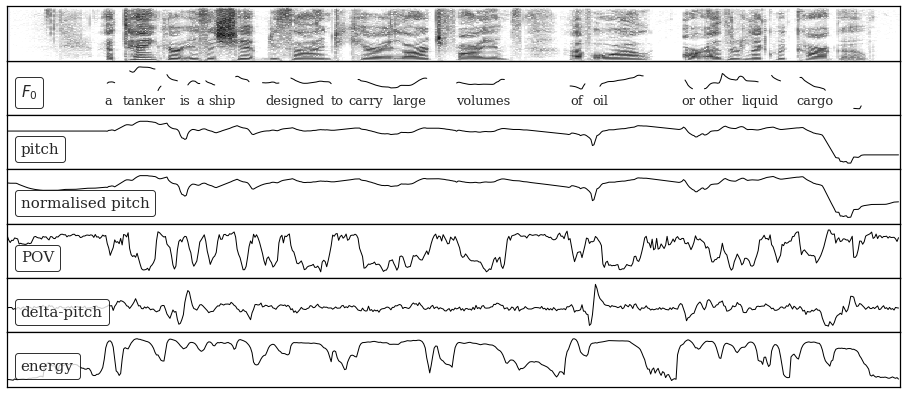

In [7]:
df = pd.read_csv("data/feats_LDC93S6A")
snd = parselmouth.Sound("data/LDC93S6A.wav")
# pov,pitch,delta-pitch,raw-log-pitch,energy,vad
columns = list(df.columns)
columns = ["raw-log-pitch", "pitch", "pov", "delta-pitch", "energy"]
labels = ["pitch", "normalised pitch", "POV", "delta-pitch", "energy"]
n_rows = len(columns) + 2
n_frames = df.shape[0]
print("{} frames".format(n_frames))
colour = "black"
w = 16
v_margin = 0.15
fig, axs = plt.subplots(nrows=n_rows, ncols=1, sharex=True, sharey=False, figsize=(w, 7))
plt.subplots_adjust(hspace=0.0)

# Spectrogram
ax = graphing.insert_axis(axs[0], fig, rect=[0.0,0.0,1.0,1.0])
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.025, time_step=0.01, maximum_frequency=8000)
print(spectrogram.values.shape)
draw_spectrogram(spectrogram, ax, fig)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_xlim(left=0, right=spectrogram.values.shape[1])
# plt.show()

# F0
pitch = snd.to_pitch_ac(time_step=0.01, pitch_floor=50, pitch_ceiling=500.0) 
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values==0] = np.nan
print("{} F_0 frames".format(len(pitch_values)))
data_line =[{
            "values": pitch_values,
            "xs": np.array(range(len(pitch_values)))+6,
            "label": "$F_0$",
            "colour": colour,
            "symbol": "."
        }]
ax = axs[1]
maximum = pitch_values[np.isnan(pitch_values) == False].max()
minimum = pitch_values[np.isnan(pitch_values) == False].min()
val_range = maximum - minimum
ymax = maximum + v_margin*val_range
ymin = minimum - v_margin*val_range
graphing.plot_linear(data_line, use_legend=True, legend_loc=3, fig=fig, drawLegendLines=False,
            ax=ax, linewidth=1.0, markersize=0, tight_layout=False, ymin=ymin, ymax=ymax)
ax.set_xlim(left=0, right=len(pitch_values))

# Prosodic features + VAD
for i, col in enumerate(columns):
    label = labels[i]
    data_line =[{
            "values": df[col],
            "xs": df.index,
            "label": label,
            "colour": colour,
            "symbol": "."
        }]
    maximum = df[col].max()
    minimum = df[col].min()
    val_range = maximum - minimum
    ymax = maximum + v_margin*val_range
    ymin = minimum - v_margin*val_range
    
    ax = axs[i+2]
    fig = graphing.plot_linear(data_line, use_legend=True, legend_loc=3, fig=fig, drawLegendLines=False,
                      ax=ax, linewidth=1.0, markersize=0, tight_layout=False, ymin=ymin, ymax=ymax)
    ax.set_xlim(left=0, right=n_frames)

# Disable axis ticks
for ax in axs:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

# Word annotation
words = ["a", "tanker", "is", "a", "ship", "designed", "to", "carry", 
         "large", "volumes", "of", "oil", "or", "other", "liquid", "cargo"]
word_points = [65, 77, 115, 126, 134, 172, 215, 227, 256, 298, 374, 389, 448, 459, 488, 524]
for word, x in zip(words, word_points):
    axs[1].text(x + 0.01*(x-word_points[0]), 100, word, fontsize=13)

plt.show()
graphing.save_fig(fig, name="prosody_sample")

## Plotting TDNN training accuracy

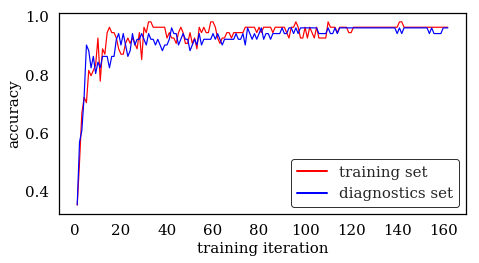

In [41]:
data = pd.read_csv("data/accuracy.output.report-mfcc", delimiter="\t", 
                   names=["iter", "dur", "train", "valid", "diff"], skiprows=[1, 164])
values = data["train"].values[1:].astype(np.float)
xs = data["iter"].values[1:].astype(np.int)

data_line =[{
    "values": values,
    "xs": xs,
    "label": "training set",
    "colour": "red",
}]

values = data["valid"].values[1:].astype(np.float)
data_line.append({
    "values": values,
    "xs": xs,
    "label": "diagnostics set",
    "colour": "blue",
})

fig = graphing.plot_linear(data_line, x_label="training iteration", y_label="accuracy", 
                legend_loc=0, figsize=(7, 4), ymin=None, ymax=None, use_legend=True, 
                title=None)
plt.show()
graphing.save_fig(fig=fig, name="acc_report_mfcc")

## Comparing experiments

In [12]:
prosody_colours = {"none": "black", "pitch": "coral", "energy": "brown", "pitch+energy": "teal", "pitch_energy": "indigo"}
prosodic_order = ["none", "pitch", "energy", "pitch+energy", "pitch_energy"]
prosodic_names = ["none", "Kaldi pitch", "raw log energy", "pitch + energy (x-vector concat.)", "pitch + energy (feature concat.)"]
acoustic_order = ["mfcc", "mfcc_deltas", "sdc", "none"]
acoustic_names = ["MFCC", "MFCC+$\Delta$+$\Delta\Delta$", "SDC", "prosody only"]

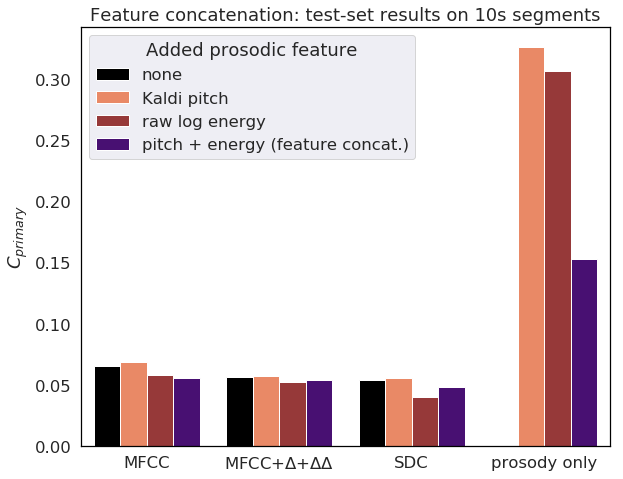

In [13]:
df = pd.read_csv("data/summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test", hue="prosodic", data=df, 
               legend_descs=remove_from_list(prosodic_names, 3), order=acoustic_order, 
               hue_order=remove_from_list(prosodic_order, 3),
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="Feature concatenation: test-set results on 10s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-feature_fusion-10s")

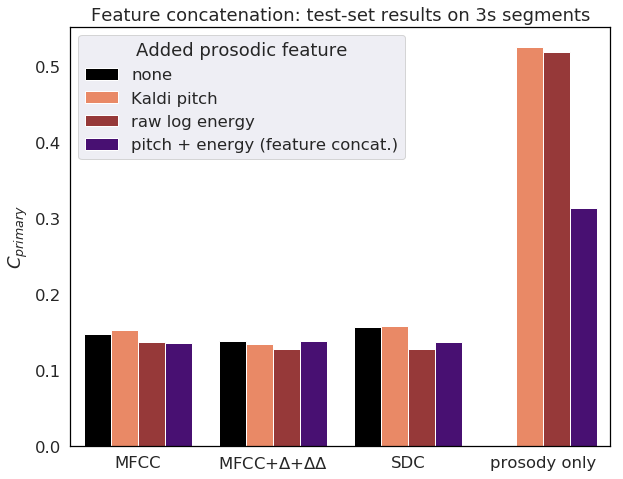

In [14]:
df = pd.read_csv("data/summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test_3s", hue="prosodic", data=df, 
               legend_descs=remove_from_list(prosodic_names, 3), order=acoustic_order, 
               hue_order=remove_from_list(prosodic_order, 3),
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="Feature concatenation: test-set results on 3s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-feature_fusion-3s")

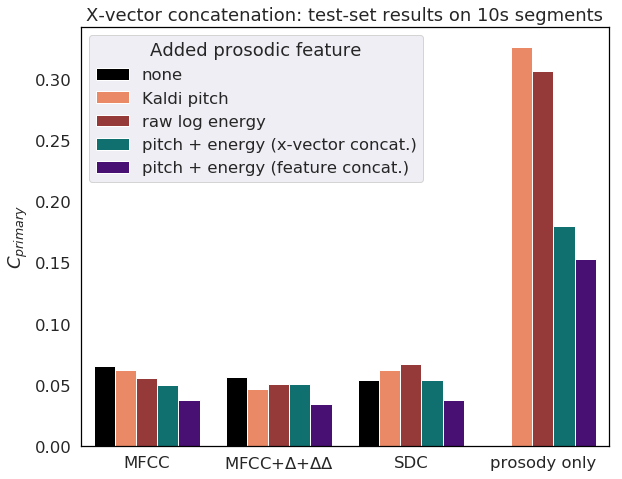

In [15]:
df = pd.read_csv("data/fusion_summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test", hue="prosodic", data=df, 
               legend_descs=prosodic_names, order=acoustic_order, hue_order=prosodic_order, 
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="X-vector concatenation: test-set results on 10s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-xvector_fusion-10s")

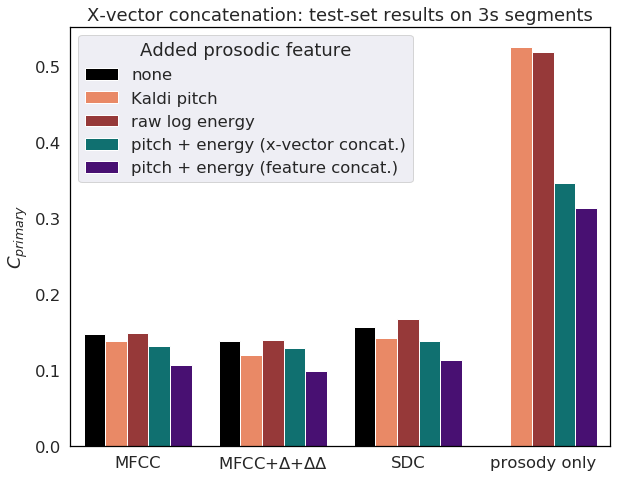

In [16]:
df = pd.read_csv("data/fusion_summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test_3s", hue="prosodic", data=df, 
               legend_descs=prosodic_names, order=acoustic_order, hue_order=prosodic_order, 
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="X-vector concatenation: test-set results on 3s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-xvector_fusion-3s")

## Final confusion matrices

In [9]:
def get_conf_mtrx(exp_name):
    filepath = "data/{}_conf_matrix-eval.csv".format(exp_name)
    mtrx = np.genfromtxt (filepath, delimiter=",", skip_header=1)
    normaliser = np.repeat(mtrx.sum(axis=1), 19).reshape((19,19))
    mtrx_normalised = 100*(np.divide(mtrx, normaliser))
    return mtrx_normalised

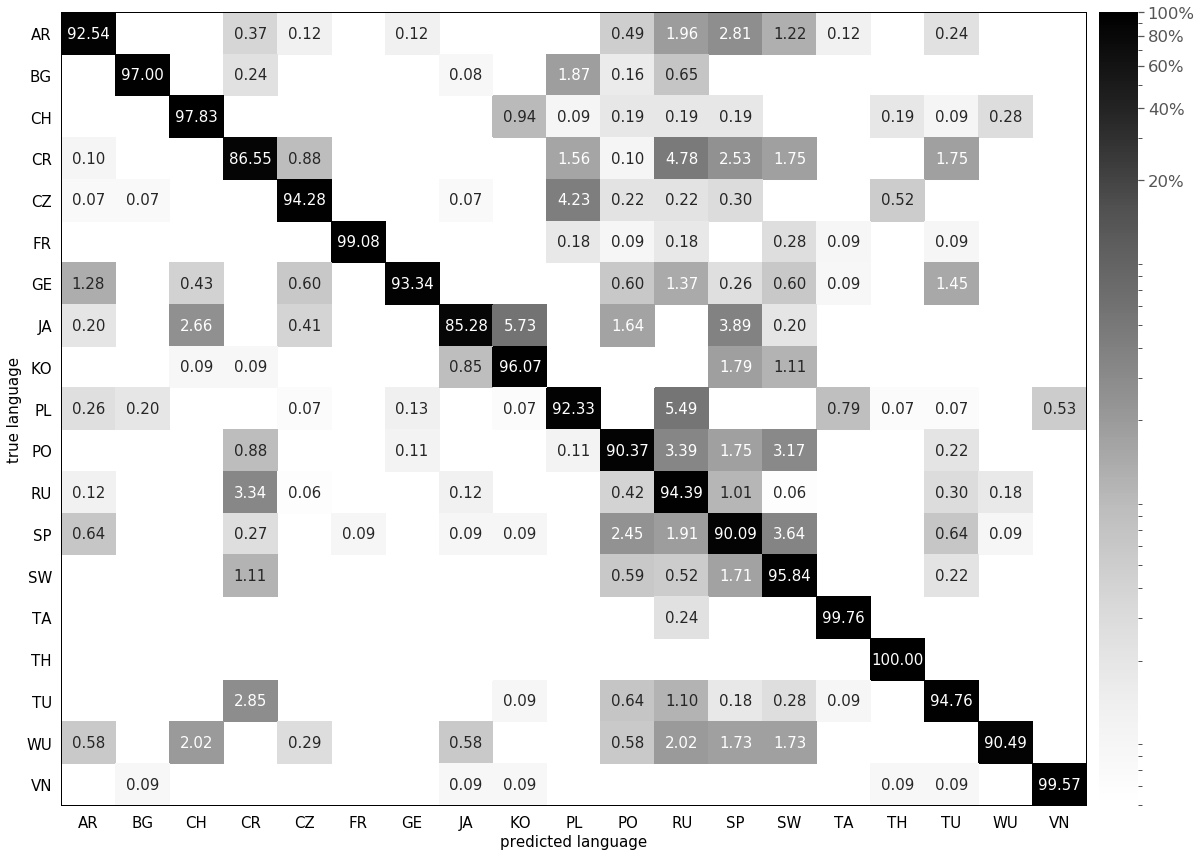

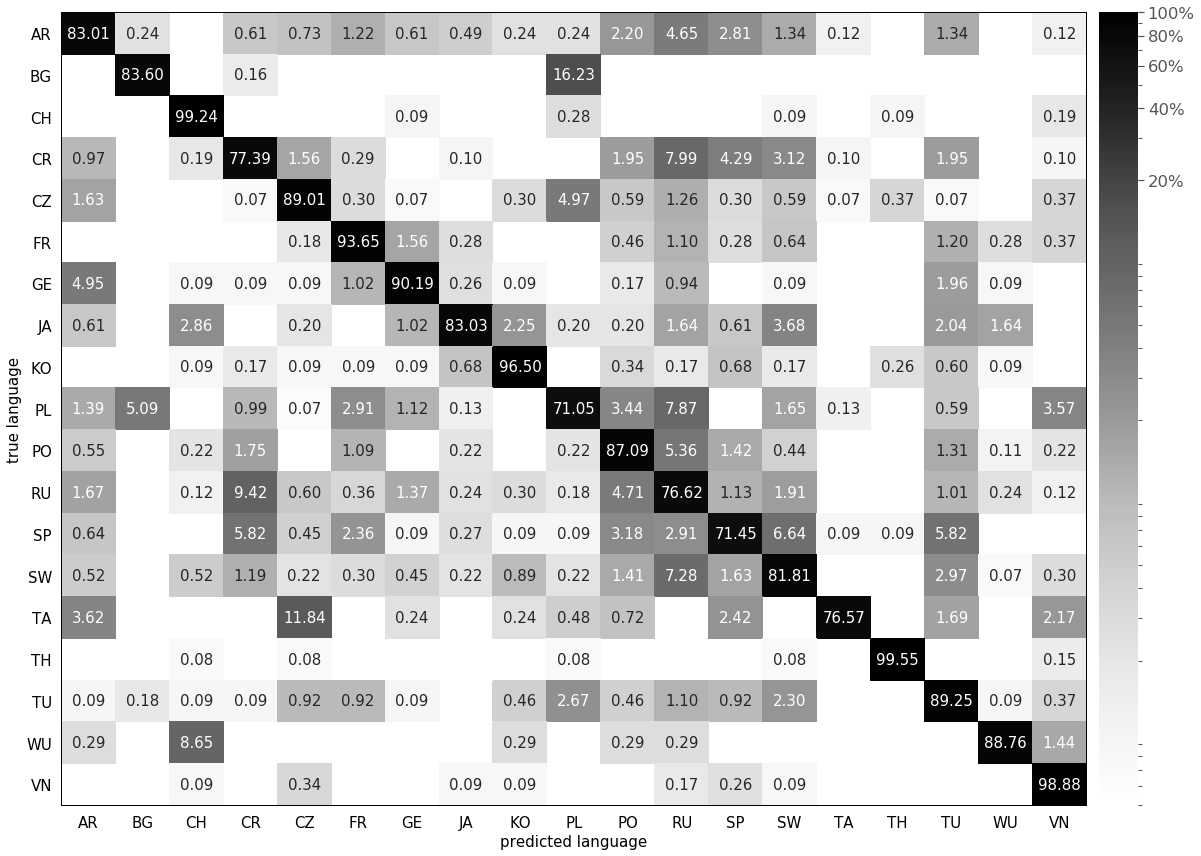

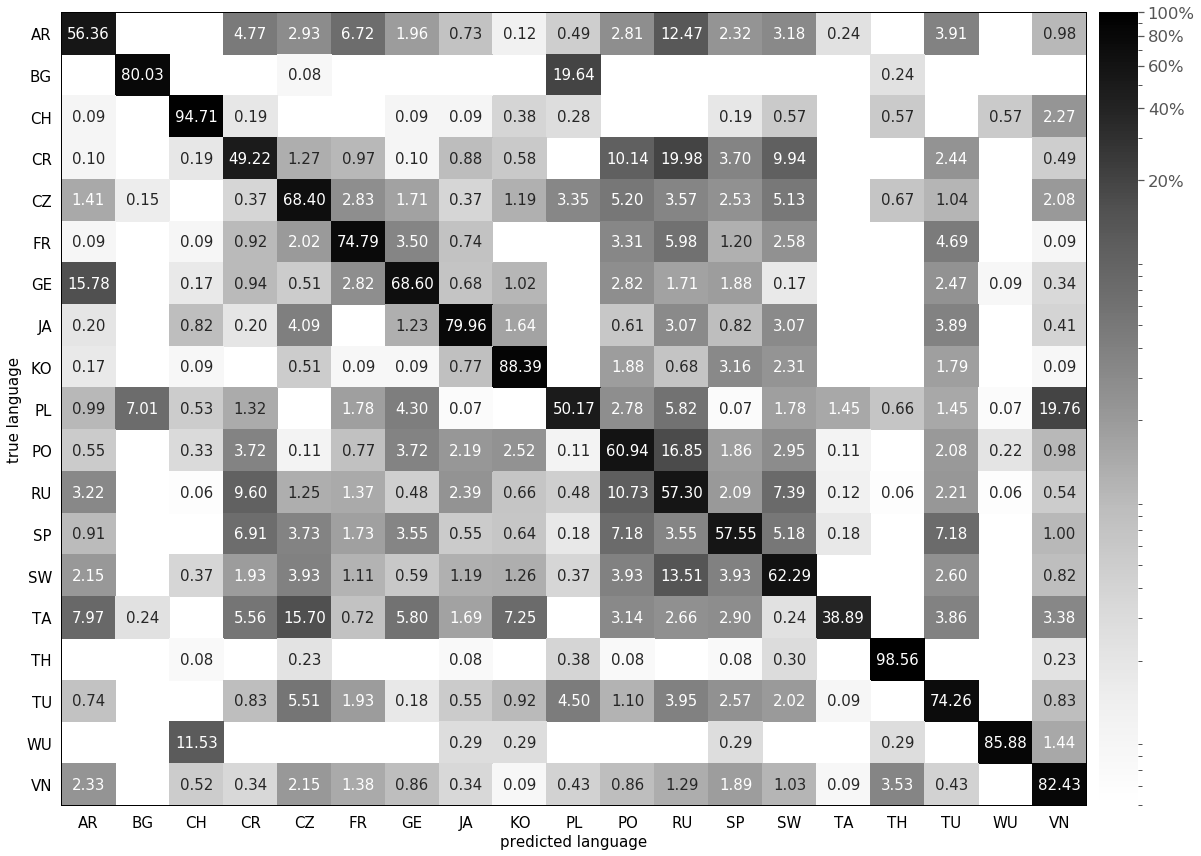

In [26]:
for exp_name in ["mfcc_deltas_pitch_energy", "pitch_energy", "pitch"]:
    mtrx = get_conf_mtrx(exp_name)
    fig = graphing.plot_heatmap(mtrx, ys=languages, xs=languages, y_label="true language", 
                       x_label="predicted language", height=12, width=18, cmap="Greys", logColourbar=True, 
                       scale_format="%.0f%%", min_v=0.05, max_v=100, fmt=".2f")
    graphing.save_fig(fig, name="conf_mtrx_{}".format(exp_name))

## Comparing confusion matrices

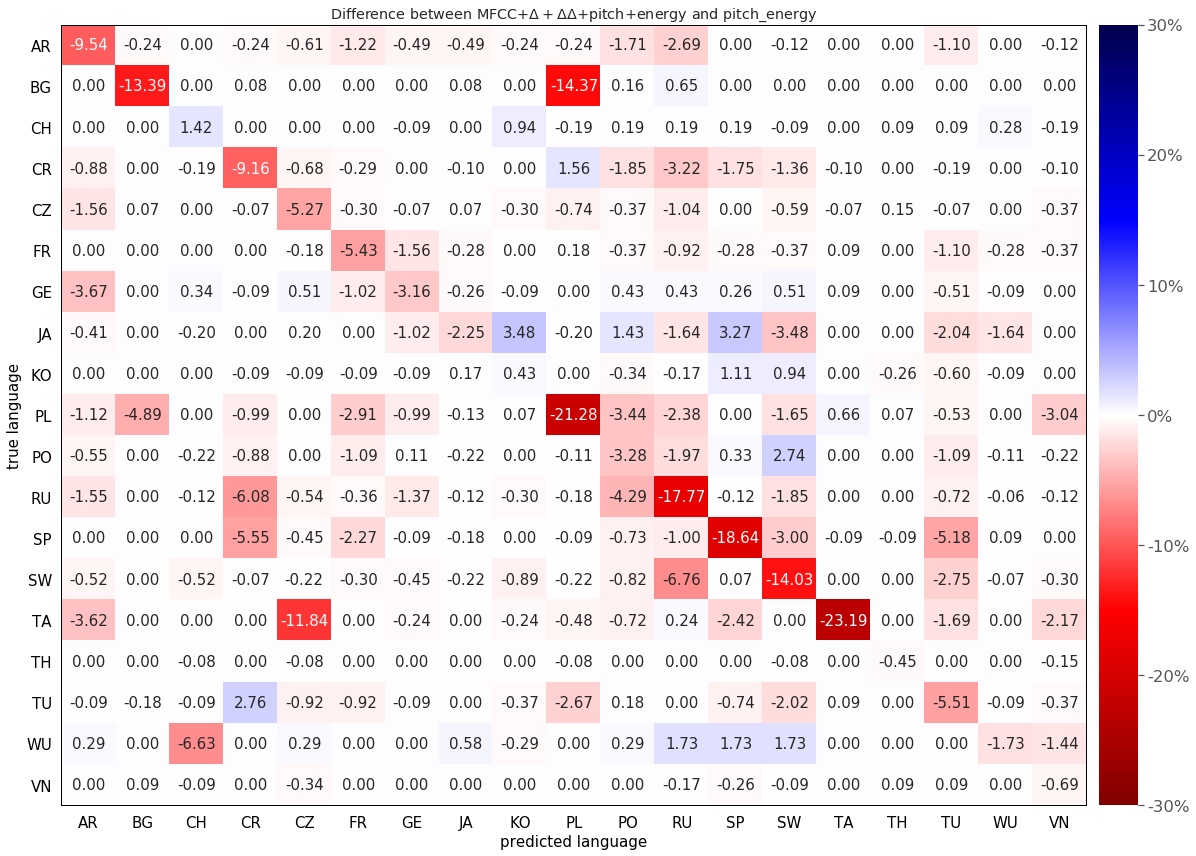

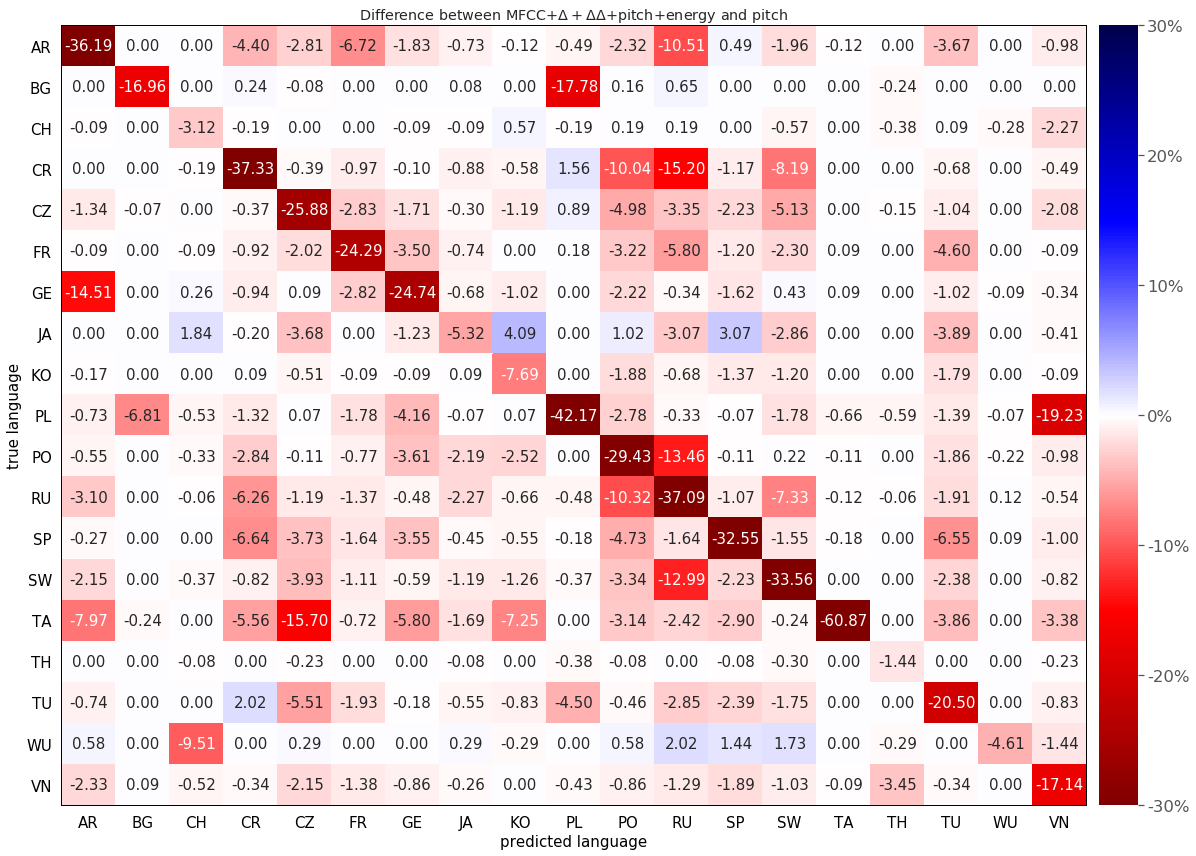

In [22]:
mtrx_best = get_conf_mtrx("mfcc_deltas_pitch_energy")
diagonal_flipper = np.ones((L, L)) - 2 * np.eye(L)
label_best = "MFCC+$\Delta+\Delta\Delta$+pitch+energy"

"""
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, 
Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, 
PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, 
RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, 
Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, 
YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, 
flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, 
gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, 
jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, 
spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, 
terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, 
winter, winter_r
"""

cmap = "hsv_r"
cmap = "seismic_r"
for prosody_exp in ["pitch_energy", "pitch"]:
    mtrx_prosodic = get_conf_mtrx(prosody_exp)
    mtrx = mtrx_best - mtrx_prosodic
    mtrx = np.multiply(mtrx, diagonal_flipper)
    fig = graphing.plot_heatmap(mtrx, ys=languages, xs=languages, y_label="true language", 
                       x_label="predicted language", height=12, width=18, cmap=cmap, logColourbar=False, 
                       scale_format="%.0f%%", min_v=-30, max_v=30, fmt=".2f", 
                       title="Difference between {} and {}".format(label_best, prosody_exp))
#     save_fig(fig, "diff_best_vs_{}".format(prosody_exp))

## Log-reg tuning

Let's see the best config overall:

In [42]:
max_steps_vals = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
normalizer_vals = [0, 0.00001, 0.0001, 0.001, 0.01]
mix_up_vals = [19, 50, 100, 150, 200, 250, 300]

# max-steps,normaliser,mix-up,acc,c_prim

file_path = "data/log-reg-gridsearch3D.txt"
grid_search_stats = pd.read_csv(file_path)
c_min = grid_search_stats["c_prim"].min()
c_max = grid_search_stats["c_prim"].max()

best_row_index = grid_search_stats["c_prim"].idxmin()
best_config = grid_search_stats.iloc[best_row_index]
print("Best values:\n{}".format(best_config))

Best values:
max-steps     100.000
normaliser      0.001
mix-up        100.000
acc             0.898
c_prim          0.136
Name: 163, dtype: float64


Okay, so this is the best one. But let's look at it more closely.

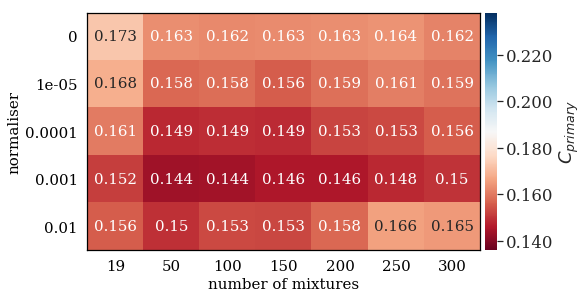

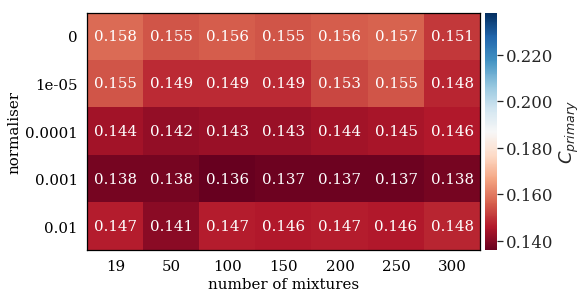

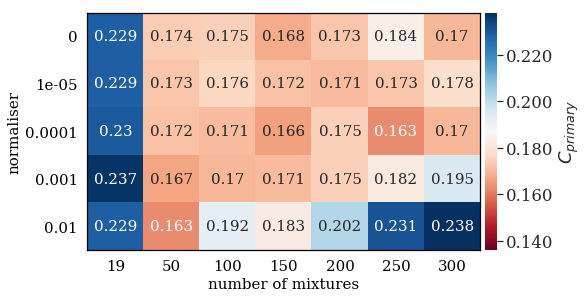

In [94]:
matrices = np.zeros((len(max_steps_vals), len(normalizer_vals), len(mix_up_vals)))

for i, max_step_val in enumerate(max_steps_vals):
    title = "C_primary dependent on normaliser and mix-up values for max-steps = {}".format(max_step_val)
    stats = grid_search_stats[grid_search_stats["max-steps"] == max_step_val]
    matrix = np.array([
                [
                    stats[(stats["mix-up"] == mix_up) & (stats["normaliser"] == norm)]["c_prim"].item()
                    for mix_up in mix_up_vals
                ] 
                for norm in normalizer_vals
             ])
    matrices[i] = matrix
h = 4.5
w = 8.5
xlabel = "number of mixtures"
# average
fig = graphing.plot_heatmap(np.average(matrices, axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="normaliser", x_label=xlabel,
             height=h, width=w, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max)
graphing.save_fig(fig, name="normaliser_vs_mix-up_avg")

# best
fig = graphing.plot_heatmap(matrices.min(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="normaliser", x_label=xlabel,
             height=h, width=w, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max)
graphing.save_fig(fig, name="normaliser_vs_mix-up_best")

# worst
fig = graphing.plot_heatmap(matrices.max(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="normaliser", x_label=xlabel,
             height=h, width=w, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max)
# graphing.save_fig(fig, name="normaliser_vs_mix-up_worst")

Okay, looks like normaliser=0.001 is a clear winner. Now what about the other two params?

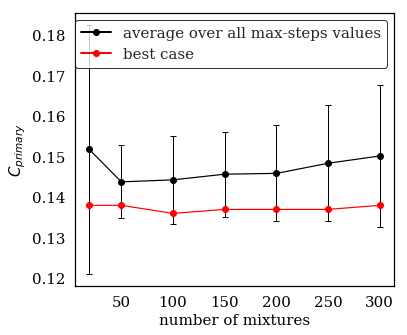

In [97]:
stats_for_fixed_normaliser = []

for mix_up_val in mix_up_vals:
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & 
                                    (grid_search_stats["mix-up"] == mix_up_val)
                                   ]["c_prim"]
    mean = data_points.mean()
    minimum = data_points.min()
    stdev = data_points.std()
    stats_for_fixed_normaliser.append(np.array([mean, stdev, minimum]))

data_line =[{
    "values": np.array(stats_for_fixed_normaliser)[:, 0],
    "xs": mix_up_vals,
    "err_bars": np.array(stats_for_fixed_normaliser)[:, 1],
    "label": "average over all max-steps values",
    "colour": "black",
    "symbol": "."
}]
data_line.append({
    "values": np.array(stats_for_fixed_normaliser)[:, 2],
    "xs": mix_up_vals,
    "label": "best case",
    "colour": "red",
    "symbol": "."
})
    
fig = graphing.plot_linear(data_line, x_label="number of mixtures", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(6, 5),
                ymin=None, ymax=None, use_legend=True)
graphing.save_fig(fig, name="logit_mix-up")

Cool, looks like numer of mixtures could be 100.

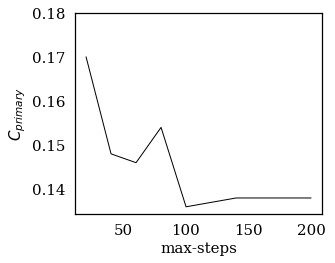

In [88]:
data_line = []
colours = ['turquoise', 'green', 'yellow', 'blue', 'red', 'navy', 'gray', 'orange', 'pink', 'black']
data_points = []
for i, max_steps_val in enumerate(max_steps_vals):
    point = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & 
                                    (grid_search_stats["max-steps"] == max_steps_val) &
                                    (grid_search_stats["mix-up"] == 100)
                                   ]["c_prim"].iloc[0]
    data_points.append(point)
    
data_line.append({
    "values": data_points,
    "xs": max_steps_vals,
    "label": None,
    "colour": colours[i],
})

fig = graphing.plot_linear(data_line, x_label="max-steps", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(5,4),
                ymin=None, ymax=0.18, linewidth=1, use_legend=False)

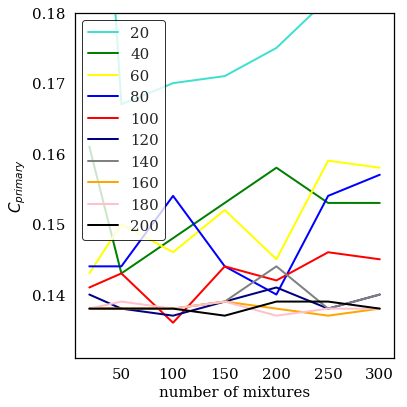

In [98]:
data_line = []
colours = ['turquoise', 'green', 'yellow', 'blue', 'red', 'navy', 'gray', 'orange', 'pink', 'black']
for i, max_steps_val in enumerate(max_steps_vals):
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & (grid_search_stats["max-steps"] == max_steps_val)]["c_prim"]
    data_line.append({
        "values": data_points,
        "xs": mix_up_vals,
        "label": "{}".format(max_steps_val),
        "colour": colours[i],
    })

fig = graphing.plot_linear(data_line, x_label="number of mixtures", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(6, 6),
                ymin=None, ymax=0.18, linewidth=2)
graphing.save_fig(fig, name="logit_max-steps_vs_mix-up")

It's clear now that the more steps, the more stable curve. That's what we want. Let's go with max-steps=200. And number of mixtures doesn't seem to matter too much, so let's use the smallest value that gives good results for high numbers of steps. That's 100.

To recap: `normaliser=0.001, max-steps=200, mix-up=100`.

## TDNN training epochs tuning

3-epoch training on its own took 8h11min=8.18333h (for 70 iterations), which gives slightly over 7min/iteration (precisely, 7.0142857min).

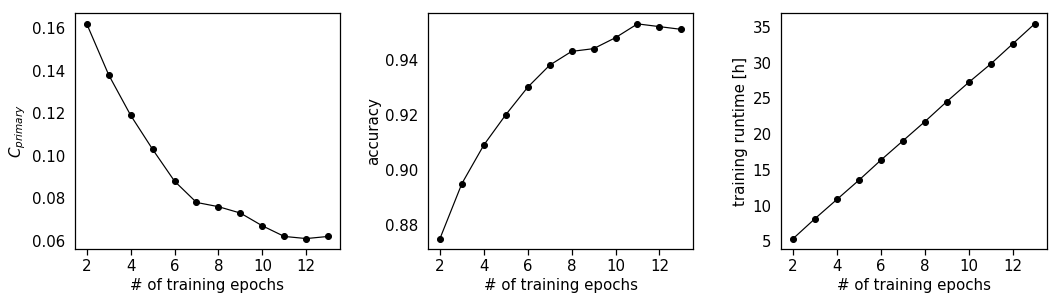

<Figure size 360x252 with 0 Axes>

<Figure size 360x252 with 0 Axes>

<Figure size 360x252 with 0 Axes>

In [175]:
epochs_vals = list(range(2, 14))

# epochs,acc,c_prim,num_iters
file_path = "data/dnn-num-epochs-search.txt"
stats = pd.read_csv(file_path)
xlabel = "# of training epochs"
fsize = (5, 3.5)
xs = stats["epochs"].astype(np.int)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
data_line =[{
    "values": stats["c_prim"],
    "xs": xs,
    "label": None,
    "colour": "black",
    "symbol": "."
}]
graphing.plot_linear(data_line, x_label=xlabel, y_label="$C_{primary}$", ax=ax, int_ticklabels="x",
                     legend_loc=0, figsize=fsize, ymin=None, ymax=None, use_legend=False, 
                     tight_layout=False, show_ticks="x")

ax = axes[1]
data_line =[{
    "values": stats["acc"],
    "xs": xs,
    "label": None,
    "colour": "black",
    "symbol": "."
}]
graphing.plot_linear(data_line, x_label=xlabel, y_label="accuracy", ax=ax, int_ticklabels="x",
                     legend_loc=0, figsize=fsize, ymin=None, ymax=None, use_legend=False, tight_layout=False,
                     show_ticks="x")

ax = axes[2]
data_line =[{
    "values": stats["num_iters"]*7.0142857/60,
    "xs": xs,
    "label": None,
    "colour": "black",
    "symbol": "."
}]
graphing.plot_linear(data_line, x_label=xlabel, y_label="training runtime [h]", ax=ax, int_ticklabels="x",
                     legend_loc=0, figsize=fsize, ymin=None, ymax=None, use_legend=False, tight_layout=False,
                     show_ticks="x")

fig.subplots_adjust(wspace=0.33, bottom=0.15, top=0.97, left=0.07, right=0.97)
plt.tight_layout()
plt.show()
graphing.save_fig(fig=fig, name="num-epochs")